In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch.callbacks as pl_callbacks
import yaml

import poregen.data
import poregen.features
import poregen.models
import poregen.trainers
import poregen.metrics

from poregen.features.feature_extractors import porosimetry
import porespy

/home/danilo/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# compute latent distribution

# data
datalist = ['/home/danilo/repos/PoreGen/saveddata/raw/imperial_college/Bentheimer_1000c_3p0035um.raw',
    '/home/danilo/repos/PoreGen/saveddata/raw/imperial_college/Doddington_1000c_2p6929um.raw',
    '/home/danilo/repos/PoreGen/saveddata/raw/imperial_college/Estaillades_1000c_3p31136um.raw',
    '/home/danilo/repos/PoreGen/saveddata/raw/imperial_college/Ketton_1000c_3p00006um.raw']

device=6
cfgpath = '/home/danilo/repos/PoreGen/configs/bps/20241029-bps-ldmvae-4imperial.yaml'
data_path = '/home/danilo/repos/PoreGen/saveddata/raw/imperial_college/Bentheimer_1000c_3p0035um.raw'
imagesize = 256
nsamples = 1
max_batch_size = 1

with torch.inference_mode():
    poregen.trainers.pore_vae_eval(cfgpath, 'best', nsamples=nsamples, device_id=device, tag='bntheimer',
                                image_size=imagesize, maximum_batch_size=max_batch_size)

/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/checkpoints
Working with z of shape (1, 4, 8, 8, 8) = 2048 dimensions.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [13]:
import json

f = '/home/danilo/repos/PoreGen/savedmodels/experimental/20241107-bps-ldm-bentheimer256/stats/stats-100-default/model-epoch=049-val_loss=0.054713/generated_stats.json'

with open(f) as ff:
    data = json.load(ff)


In [17]:
for k, v in data.items():
    print(k, v['porosity'])

00001 [0.1653253436088562]
00002 [0.14339518547058105]
00003 [0.14897191524505615]
00004 [0.2057998776435852]
00005 [0.1342199444770813]
00006 [0.1463778018951416]
00007 [0.1407707929611206]
00008 [0.2201666235923767]
00009 [0.19724106788635254]
00010 [0.19942551851272583]
00011 [0.17609769105911255]
00012 [0.1423037052154541]
00013 [0.14812499284744263]
00014 [0.20125550031661987]
00015 [0.19967544078826904]
00016 [0.21667706966400146]
00017 [0.16526180505752563]
00018 [0.13703536987304688]
00019 [0.19939905405044556]
00020 [0.14188152551651]
00021 [0.14442306756973267]
00022 [0.13463479280471802]
00023 [0.1383143663406372]
00024 [0.1335192322731018]
00025 [0.15071147680282593]
00026 [0.12373626232147217]
00027 [0.13946664333343506]
00028 [0.15037143230438232]
00029 [0.1486092209815979]
00030 [0.14682090282440186]
00031 [0.1378880739212036]
00032 [0.1426488161087036]
00033 [0.13572752475738525]
00034 [0.1305149793624878]
00035 [0.1295006275177002]
00036 [0.13463789224624634]
00037 [0.

TypeError: 'NoneType' object is not subscriptable

In [4]:
z_bent = np.load('/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-1-vae-bntheimer/model-epoch=060-val_loss=0.002525/latent_samples/00000_z.npy')
z_ketton = np.load('/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-1-vae-ketton/model-epoch=060-val_loss=0.002525/latent_samples/00000_z.npy')

In [5]:
min1, max1 = np.min(z_bent), np.max(z_bent)
min2, max2 = np.min(z_ketton), np.max(z_ketton)
min1, min2, max1, max2

(-21.343798, -21.31462, 21.801329, 21.312256)

In [6]:
np.mean(z_bent), np.mean(z_ketton)

(0.9245509, 0.9670573)

In [9]:
# compute variances
datafolder = '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-100-vae-estaillades/model-epoch=060-val_loss=0.002525/latent_samples'
savefolder = '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-100-vae-estaillades/model-epoch=060-val_loss=0.002525'
nsamples = 100
poregen.features.diagonal_variance(datafolder, savefolder, nsamples)


Scalar mean: 1.0090723037719727
Diagonal variance: 33.85483120918274


Reconstruction error plots saved to /home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/reconstruction_errors.png


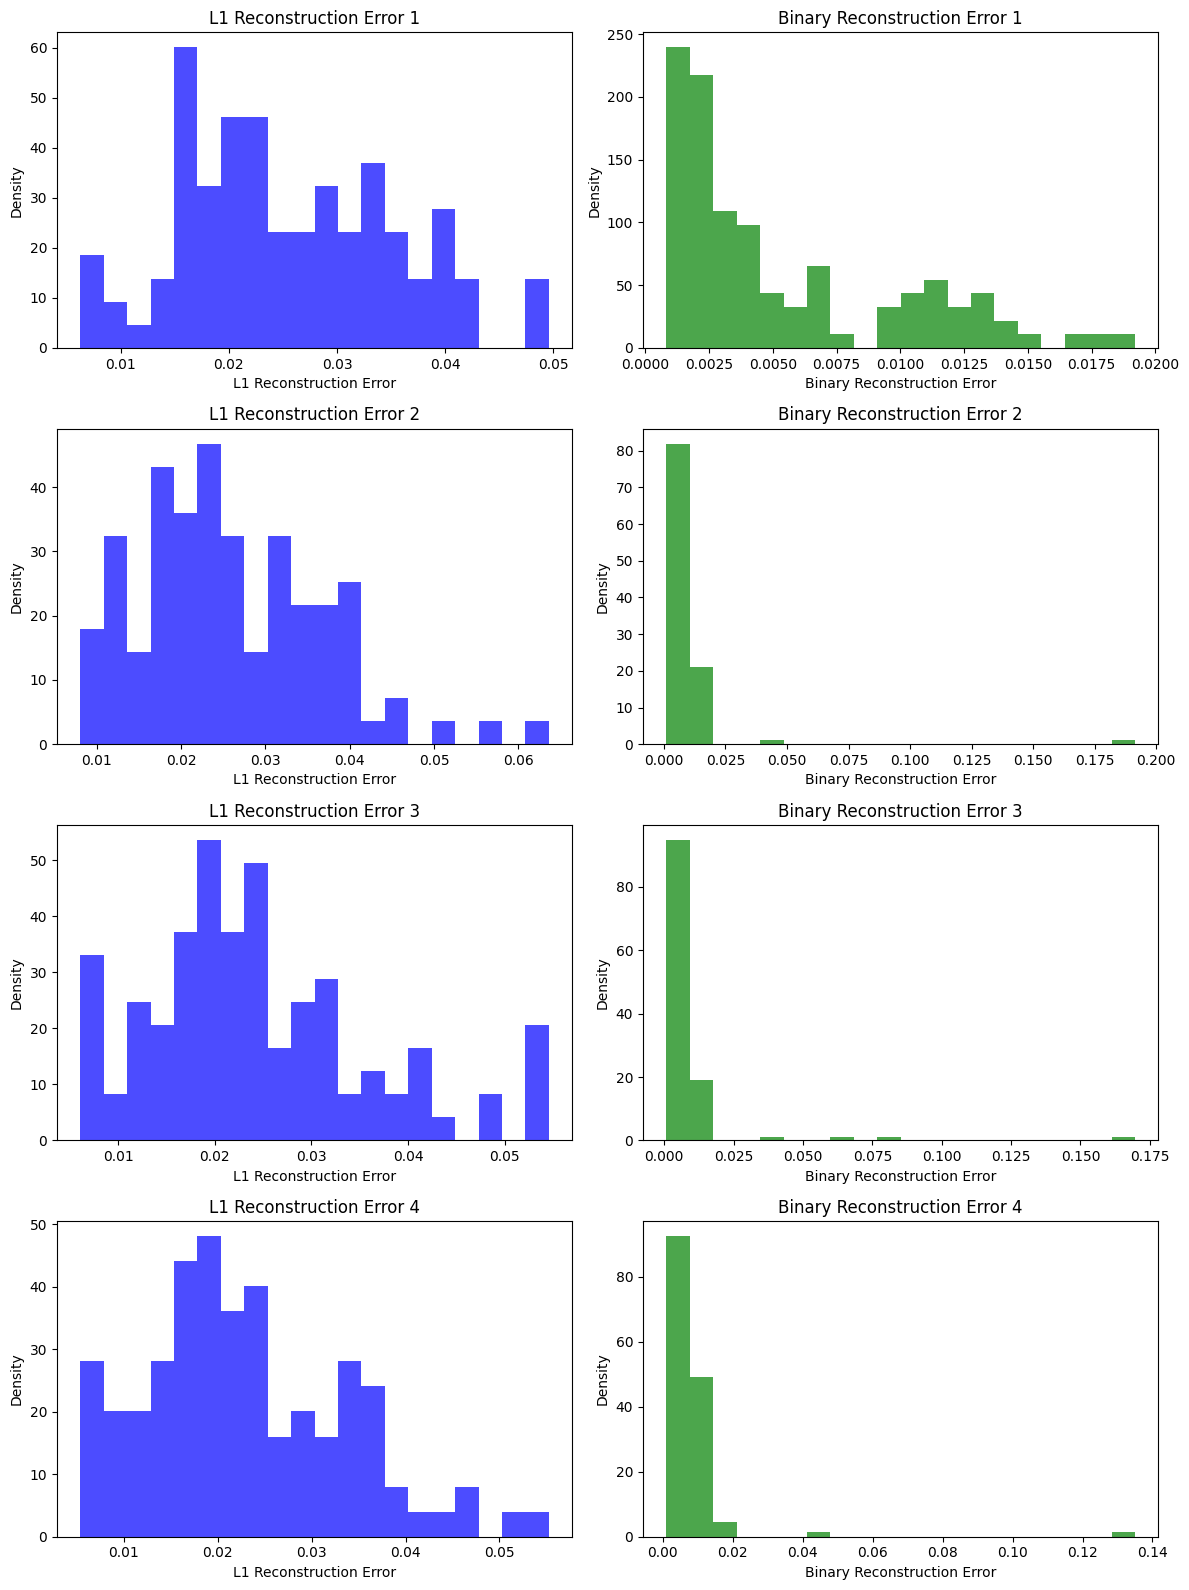

In [10]:
# plot vae reconstruction errors

datapath = ['/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-100-vae-bentheimer/model-epoch=060-val_loss=0.002525',
            '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-100-vae-doddington/model-epoch=060-val_loss=0.002525',
            '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-100-vae-estaillades/model-epoch=060-val_loss=0.002525',
            '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-100-vae-ketton/model-epoch=060-val_loss=0.002525']

savefolder = '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial'
poregen.metrics.plot_vae_reconstruction_errors(datapath, savefolder)

In [ ]:
# plot vae reconstruction

# datapath = '/home/danilo/repos/PoreGen/savedmodels/production/20241029-bps-ldmvae-4imperial/stats/stats-1-vae/model-epoch=060-val_loss=0.002525'
# poregen.metrics.plot_vae_reconstruction(datapath, nsamples=1)